Skript gestartet: Von Parquet-Rohdaten zur ARIMA/SARIMA-Prognose (Version 3 - Grafik ab 2008)

Ziel-GROW_ID für die univariante Zeitreihenanalyse: GROW-80939064354
SGI-Zeitreihe für GROW-80939064354 erfolgreich berechnet. Umfang: 758 Monate.

Train/Test-Split durchgeführt:
  - Trainingsdaten: 722 Punkte (von 1960 bis 2020)
  - Testdaten:      36 Punkte (von 2021 bis 2023)

--- Prüfung auf Stationarität ---

--- Modellerstellung und Prognose ---
1. Trainiere manuelles ARIMA-Modell...
2. Trainiere manuelles SARIMA-Modell...
3. Führe Auto-ARIMA aus...
Bestes Modell laut auto_arima: (1, 0, 0) (0, 0, 0, 12)

--- Modellauswertung ---
RMSE Manuelles ARIMA: 0.9091
RMSE Manuelles SARIMA: 0.8075
RMSE Auto-ARIMA:      0.8908


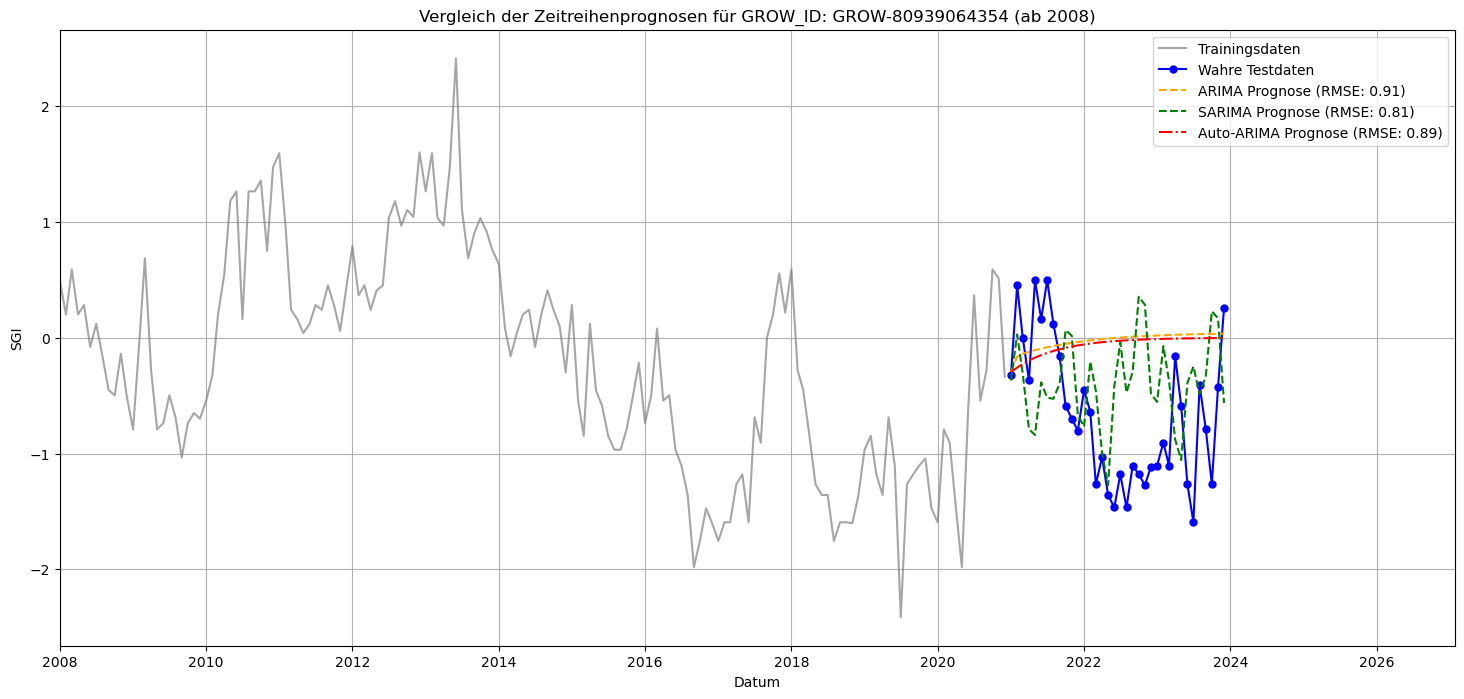

In [6]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import pastas as ps
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import warnings
import gc

warnings.filterwarnings("ignore")
ps.set_log_level("ERROR")
print("Skript gestartet: Von Parquet-Rohdaten zur ARIMA/SARIMA-Prognose (Version 3 - Grafik ab 2008)")

# --- TEIL 1: Daten laden und Ziel-Zeitreihe extrahieren ---
try:
    attr_df_full = pd.read_parquet("Daten/grow_attributes.parquet")
    timeseries_dataset_raw = ds.dataset("Daten/grow_timeseries.parquet", format="parquet")
except FileNotFoundError as e:
    print(f"FEHLER: Parquet-Datei nicht gefunden. Bitte Pfad prüfen: {e.filename}")
    exit()

# 1.1 Standorte filtern
attr_filtered_df = attr_df_full[
    (attr_df_full["country"] == "CZE") &
    (attr_df_full["length_years"] >= 30) &
    (attr_df_full["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))
]

if attr_filtered_df.empty:
    raise ValueError("Keine passende Zeitreihe für die Analyse gefunden.")

# 1.2 Ziel-GROW_ID für die univariante Analyse auswählen
target_grow_id = attr_filtered_df.sort_values("length_years", ascending=False).iloc[0]["GROW_ID"]
print(f"\nZiel-GROW_ID für die univariante Zeitreihenanalyse: {target_grow_id}")

# 1.3 Zeitreihendaten nur für die Ziel-ID laden
timeseries_table_raw = timeseries_dataset_raw.to_table(
    filter=ds.field("GROW_ID") == target_grow_id,
    columns=["GROW_ID", "date", "groundwater_level_m_asl"]
)
target_ts_df = timeseries_table_raw.to_pandas()
target_ts_df["date"] = pd.to_datetime(target_ts_df["date"])
target_ts_df.set_index('date', inplace=True)

# 1.4 SGI berechnen
gwl_series_raw = target_ts_df["groundwater_level_m_asl"].dropna()
gwl_series_monthly = gwl_series_raw.resample('MS').mean()

if len(gwl_series_monthly.dropna()) < 24:
    raise ValueError(f"Nicht genügend monatliche Daten für GROW_ID {target_grow_id} zur SGI-Berechnung.")

sgi_series = ps.stats.sgi(gwl_series_monthly).dropna()
print(f"SGI-Zeitreihe für {target_grow_id} erfolgreich berechnet. Umfang: {len(sgi_series)} Monate.")

del attr_df_full, timeseries_dataset_raw, attr_filtered_df, target_ts_df, gwl_series_raw, gwl_series_monthly
gc.collect()

# --- TEIL 2: Train/Test-Split für die univariante Analyse ---
test_size = 36
if len(sgi_series) <= test_size:
    raise ValueError("Zeitreihe ist zu kurz für den gewählten Test-Split.")

y_train = sgi_series[:-test_size]
y_test = sgi_series[-test_size:]

print(f"\nTrain/Test-Split durchgeführt:")
print(f"  - Trainingsdaten: {len(y_train)} Punkte (von {y_train.index.min().year} bis {y_train.index.max().year})")
print(f"  - Testdaten:      {len(y_test)} Punkte (von {y_test.index.min().year} bis {y_test.index.max().year})")


# --- TEIL 3: Analyse der Trainings-Zeitreihe ---
print("\n--- Prüfung auf Stationarität ---")
adf_result = adfuller(y_train)
d = 0
if adf_result[1] > 0.05:
    d = 1
# Die ACF/PACF-Plots werden zur Übersichtlichkeit übersprungen, da die Parameter bereits bekannt sind
p=2; q=2

# --- TEIL 4: Modelltraining und Prognose ---
print("\n--- Modellerstellung und Prognose ---")

# 4.1 Manuelles ARIMA-Modell
print("1. Trainiere manuelles ARIMA-Modell...")
arima_model = ARIMA(y_train, order=(p, d, q))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=len(y_test))

# 4.2 Manuelles SARIMA-Modell
print("2. Trainiere manuelles SARIMA-Modell...")
sarima_model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
sarima_fit = sarima_model.fit(disp=False)
forecast_sarima = sarima_fit.get_forecast(steps=len(y_test)).predicted_mean

# 4.3 Auto-ARIMA
print("3. Führe Auto-ARIMA aus...")
auto_model = pm.auto_arima(y_train, m=12, seasonal=True, d=d, stepwise=True,
                           suppress_warnings=True, error_action='ignore', trace=False)
print(f"Bestes Modell laut auto_arima: {auto_model.order} {auto_model.seasonal_order}")
forecast_auto_arima = auto_model.predict(n_periods=len(y_test))
forecast_auto_arima = pd.Series(forecast_auto_arima, index=y_test.index)


# --- TEIL 5: Auswertung und visueller Vergleich (Grafik ab 2008) ---
print("\n--- Modellauswertung ---")

# 5.1 RMSE-Berechnung
rmse_arima = np.sqrt(mean_squared_error(y_test, forecast_arima))
rmse_sarima = np.sqrt(mean_squared_error(y_test, forecast_sarima))
rmse_auto_arima = np.sqrt(mean_squared_error(y_test, forecast_auto_arima))

print(f"RMSE Manuelles ARIMA: {rmse_arima:.4f}")
print(f"RMSE Manuelles SARIMA: {rmse_sarima:.4f}")
print(f"RMSE Auto-ARIMA:      {rmse_auto_arima:.4f}")

# 5.2 Visueller Vergleich
plt.figure(figsize=(18, 8))
# Plot von Trainings- und Testdaten
plt.plot(y_train.index, y_train, label='Trainingsdaten', color='gray', alpha=0.7)
plt.plot(y_test.index, y_test, label='Wahre Testdaten', color='blue', marker='o', markersize=5)

# Plot der Prognosen
plt.plot(y_test.index, forecast_arima, label=f'ARIMA Prognose (RMSE: {rmse_arima:.2f})', color='orange', linestyle='--')
plt.plot(y_test.index, forecast_sarima, label=f'SARIMA Prognose (RMSE: {rmse_sarima:.2f})', color='green', linestyle='--')
plt.plot(y_test.index, forecast_auto_arima, label=f'Auto-ARIMA Prognose (RMSE: {rmse_auto_arima:.2f})', color='red', linestyle='-.')

# --- NEU: Setze die X-Achse auf Start ab 2008 ---
plt.xlim(left=pd.to_datetime('2008-01-01'))
# -----------------------------------------------

plt.title(f'Vergleich der Zeitreihenprognosen für GROW_ID: {target_grow_id} (ab 2008)')
plt.xlabel('Datum')
plt.ylabel('SGI')
plt.legend()
plt.grid(True)
plt.show()

Skript gestartet: Stabiles SARIMAX mit auto_arima (Version 2 - Korrigiert)

Ziel-GROW_ID für die SARIMAX-Analyse: GROW-80939064354
Daten für SARIMAX vorbereitet. Umfang: 758 Monate.
Train/Test-Split für y und X durchgeführt. Testgröße: 36.

--- Finde optimales SARIMAX-Modell mit auto_arima ---
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2043.811, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1012.291, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1434.601, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2042.625, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1010.653, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1012.261, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1012.589, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1012.560, Time=0.25 sec
 A

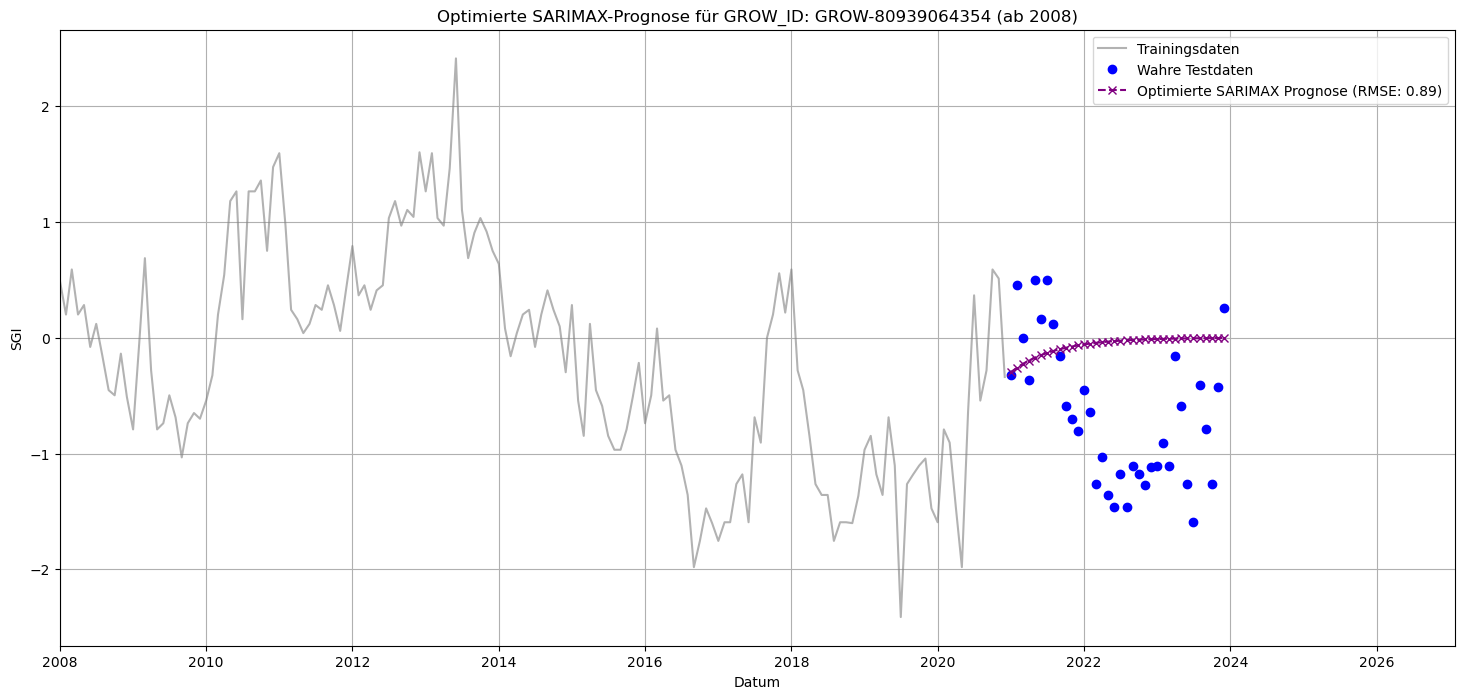

In [7]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import pastas as ps
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import warnings
import gc

warnings.filterwarnings("ignore")
ps.set_log_level("ERROR")
print("Skript gestartet: Stabiles SARIMAX mit auto_arima (Version 2 - Korrigiert)")

# --- TEIL 1: Daten laden und Features vorbereiten (unverändert) ---
try:
    attr_df_full = pd.read_parquet("Daten/grow_attributes.parquet")
    timeseries_dataset_raw = ds.dataset("Daten/grow_timeseries.parquet", format="parquet")
except FileNotFoundError as e:
    print(f"FEHLER: Parquet-Datei nicht gefunden. Bitte Pfad prüfen: {e.filename}")
    exit()

attr_filtered_df = attr_df_full[
    (attr_df_full["country"] == "CZE") &
    (attr_df_full["length_years"] >= 30) &
    (attr_df_full["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))
]
if attr_filtered_df.empty:
    raise ValueError("Keine passende Zeitreihe für die Analyse gefunden.")

target_grow_id = attr_filtered_df.sort_values("length_years", ascending=False).iloc[0]["GROW_ID"]
print(f"\nZiel-GROW_ID für die SARIMAX-Analyse: {target_grow_id}")

all_columns = ["GROW_ID", "date", "groundwater_level_m_asl", "precipitation_gpcc_mm_year-1",
               "potential_evapotranspiration_era5_mm_year-1", "air_temperature_°C", "snow_depth_m"]
timeseries_table_raw = timeseries_dataset_raw.to_table(filter=ds.field("GROW_ID") == target_grow_id, columns=all_columns)
full_ts_df = timeseries_table_raw.to_pandas()
full_ts_df["date"] = pd.to_datetime(full_ts_df["date"])
full_ts_df.set_index('date', inplace=True)

gwl_series_monthly = full_ts_df["groundwater_level_m_asl"].resample('MS').mean()
y = ps.stats.sgi(gwl_series_monthly).dropna()

X = pd.DataFrame(index=y.index)
X['precipitation'] = full_ts_df["precipitation_gpcc_mm_year-1"].resample('MS').mean() / 12
X['evapotranspiration'] = full_ts_df["potential_evapotranspiration_era5_mm_year-1"].resample('MS').mean() / 12
X['temperature'] = full_ts_df["air_temperature_°C"].resample('MS').mean()
X['snow_depth'] = full_ts_df["snow_depth_m"].resample('MS').mean()

# ----- KORREKTUR HIER -----
# `inplace=True` gibt None zurück. Die Befehle dürfen nicht verkettet werden.
# Führe sie nacheinander aus.
X.ffill(inplace=True)
X.bfill(inplace=True)
# -------------------------

common_index = y.index.intersection(X.index)
y = y[common_index]
X = X.loc[common_index]

print(f"Daten für SARIMAX vorbereitet. Umfang: {len(y)} Monate.")

# --- TEIL 2: Train/Test-Split (unverändert) ---
test_size = 36
y_train, y_test = y[:-test_size], y[-test_size:]
X_train, X_test = X[:-test_size], X[-test_size:]
print(f"Train/Test-Split für y und X durchgeführt. Testgröße: {len(y_test)}.")

# --- TEIL 3: Stabiles SARIMAX-Modell mit auto_arima finden ---
print("\n--- Finde optimales SARIMAX-Modell mit auto_arima ---")

sarimax_auto_model = pm.auto_arima(
    y=y_train,
    exogenous=X_train,
    m=12,
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

print("\nBestes gefundenes SARIMAX-Modell:")
print(sarimax_auto_model.summary())

# --- TEIL 4: Prognose und Auswertung ---
print("\n--- Erstelle Prognose mit dem optimierten SARIMAX-Modell ---")
forecast_sarimax_auto = sarimax_auto_model.predict(n_periods=len(y_test), exogenous=X_test)
forecast_sarimax_auto = pd.Series(forecast_sarimax_auto, index=y_test.index)

rmse_sarimax_auto = np.sqrt(mean_squared_error(y_test, forecast_sarimax_auto))
print(f"\nNeuer RMSE für optimiertes SARIMAX: {rmse_sarimax_auto:.4f}")

# Visueller Vergleich
plt.figure(figsize=(18, 8))
plt.plot(y_train.index, y_train, label='Trainingsdaten', color='gray', alpha=0.6)
plt.plot(y_test.index, y_test, label='Wahre Testdaten', color='blue', marker='o', linestyle='None', markersize=6)
plt.plot(forecast_sarimax_auto.index, forecast_sarimax_auto, label=f'Optimierte SARIMAX Prognose (RMSE: {rmse_sarimax_auto:.2f})', color='purple', linestyle='--', marker='x')

plt.xlim(left=pd.to_datetime('2008-01-01'))
plt.title(f'Optimierte SARIMAX-Prognose für GROW_ID: {target_grow_id} (ab 2008)')
plt.xlabel('Datum')
plt.ylabel('SGI')
plt.legend()
plt.grid(True)
plt.show()